# **Import Libraries**
Importing necessary libraries for data manipulation, visualization, and clustering.


In [1]:
# %%capture
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# **Load and Sample Data**
Loading the datasets and sampling a fraction of them to speed up processing.


In [2]:
# Load the datasets
train_df = pd.read_csv("train.csv", index_col='id')
test_df = pd.read_csv("test.csv", index_col='id')

# **Transform Binary Variables**
Mapping binary variables to numerical values and defining binary variables.


In [3]:
# Transform binary variables
train_df['Gender'] = train_df['Gender'].map({'Male': 1, 'Female': 0})
train_df['Vehicle_Damage'] = train_df['Vehicle_Damage'].map({'Yes': 1, 'No': 0})

# Define binary variables
binary = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Damage', 'Response']

# Drop Driving_License due to limited variability
train_df = train_df.drop(['Driving_License'], axis=1)


# **Group Rare Categories**
Grouping rare categories in categorical variables to reduce the dimensionality.


In [4]:
# Define categorical variables
categorical = ['Region_Code', 'Vehicle_Age', 'Policy_Sales_Channel']

# Function to group rare categories
def group_rare_categories(df, column, threshold=0.01):
    category_freq = df[column].value_counts(normalize=True)
    rare_categories = category_freq[category_freq < threshold].index
    df[column] = df[column].apply(lambda x: 'Other' if x in rare_categories else x)
    return df

# Group rare categories in categorical variables
train_df = group_rare_categories(train_df, 'Region_Code', 0.01)
train_df = group_rare_categories(train_df, 'Policy_Sales_Channel', 0.01)


# **Handle Continuous Variables**
Handling outliers and standardizing continuous numeric variables.


In [5]:
# Define continuous numeric variables
continuous_numeric = ['Age', 'Vintage', 'Annual_Premium']

# Calculate the IQR for Annual_Premium
Q1 = train_df['Annual_Premium'].quantile(0.25)
Q3 = train_df['Annual_Premium'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers and create an outlier flag
train_df['Outlier_Annual_Premium'] = ((train_df['Annual_Premium'] < lower_bound) | (train_df['Annual_Premium'] > upper_bound)).astype(int)

# Remove outliers from the dataset based on IQR method
train_df = train_df[(train_df['Annual_Premium'] >= lower_bound) & (train_df['Annual_Premium'] <= upper_bound)]
train_df = train_df.drop('Outlier_Annual_Premium', axis=1)

# Standardize the continuous variables
scaler = StandardScaler()
scaled_continuous_vars = scaler.fit_transform(train_df[continuous_numeric])


# **KMeans Clustering**
Applying KMeans clustering to the standardized continuous variables.


In [6]:
# Based on the elbow plot, choose the optimal number of clusters (e.g., 4)
optimal_clusters = 4

# Apply KMeans clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_continuous_vars)

# Add cluster labels to the DataFrame
train_df['Cluster'] = clusters


# **One-Hot and Ordinal Encoding**
Apply one-hot encoding to `Region_Code` and `Policy_Sales_Channel`, and ordinal encoding to `Vehicle_Age`.


In [7]:
# Ordinal Encoding for Vehicle_Age
train_df_encoded = train_df.copy()  # Create a copy of the original DataFrame
train_df_encoded['Vehicle_Age'] = train_df_encoded['Vehicle_Age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})

# One-Hot Encoding for other categorical variables
categorical = ['Region_Code', 'Policy_Sales_Channel']

# Apply one-hot encoding
train_df_encoded = pd.get_dummies(train_df_encoded, columns=categorical, drop_first=True)

# Display the first few rows of the transformed train dataset
train_df_encoded.head()


,Gender,Age,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response,Cluster,Region_Code_3.0,...,Region_Code_50.0,Region_Code_Other,Policy_Sales_Channel_122.0,Policy_Sales_Channel_124.0,Policy_Sales_Channel_152.0,Policy_Sales_Channel_154.0,Policy_Sales_Channel_156.0,Policy_Sales_Channel_157.0,Policy_Sales_Channel_160.0,Policy_Sales_Channel_Other
id,,,,,,,,,,,,,,,,,,,,,
1,1,43,0,2,1,58911.0,288,1,2,False,...,False,False,False,False,False,False,False,False,False,False
2,0,25,1,0,0,38043.0,254,0,1,False,...,False,False,False,False,True,False,False,False,False,False
4,0,36,1,1,0,31951.0,294,0,1,False,...,False,False,False,False,True,False,False,False,False,False
5,0,31,1,0,0,28150.0,197,0,1,False,...,False,False,False,False,True,False,False,False,False,False
6,1,23,1,0,0,27128.0,190,0,1,False,...,False,False,False,False,True,False,False,False,False,False


In [8]:
def feature_engineering(df):
    df['Age_Vehicle_Age'] = df['Age'] * df['Vehicle_Age']
    df['Age_Previously_Insured'] = df['Age'] * df['Previously_Insured']
    df['Vehicle_Age_Damage'] = df['Vehicle_Age'] * df['Vehicle_Damage']
    df['Previously_Insured_Damage'] = df['Previously_Insured'] * df['Vehicle_Damage']
    df['Age_squared'] = df['Age'] ** 2
    df['Vehicle_Age_squared'] = df['Vehicle_Age'] ** 2
    df['Annual_Premium_per_Age'] = df['Annual_Premium'] / (df['Age'] + 1)
    return df

# Apply feature engineering
train_df_encoded = feature_engineering(train_df_encoded)


In [9]:
# Separate features and target variable
X = train_df_encoded.drop('Response', axis=1)
y = train_df_encoded['Response']

In [10]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [11]:
# !pip install flaml

c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[flaml.automl.logger: 07-08 11:18:31] {1680} INFO - task = classification
[flaml.automl.logger: 07-08 11:18:31] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 07-08 11:18:56] {1789} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 07-08 11:18:56] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 07-08 11:18:56] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-08 11:18:59] {2345} INFO - Estimated sufficient time budget=19685720s. Estimated necessary time budget=483284s.
[flaml.automl.logger: 07-08 11:18:59] {2392} INFO -  at 103.2s,	estimator lgbm's best error=0.1545,	best estimator lgbm's best error=0.1545
[flaml.automl.logger: 07-08 11:18:59] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-08 11:19:01] {2392} INFO -  at 105.2s,	estimator lgbm's best error=0.1530,	best estimator lgbm's best error=0.1530
[flaml

c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-08 12:20:52] {2392} INFO -  at 3816.1s,	estimator lrl1's best error=0.2763,	best estimator lgbm's best error=0.1165
[flaml.automl.logger: 07-08 12:20:52] {2219} INFO - iteration 159, current learner lrl1


c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-08 12:20:54] {2392} INFO -  at 3818.3s,	estimator lrl1's best error=0.2763,	best estimator lgbm's best error=0.1165
[flaml.automl.logger: 07-08 12:20:54] {2219} INFO - iteration 160, current learner lrl1


c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-08 12:20:57] {2392} INFO -  at 3820.5s,	estimator lrl1's best error=0.2763,	best estimator lgbm's best error=0.1165
[flaml.automl.logger: 07-08 12:20:57] {2219} INFO - iteration 161, current learner lrl1


c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-08 12:21:04] {2392} INFO -  at 3827.4s,	estimator lrl1's best error=0.2585,	best estimator lgbm's best error=0.1165
[flaml.automl.logger: 07-08 12:21:04] {2219} INFO - iteration 162, current learner lrl1


c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-08 12:21:10] {2392} INFO -  at 3833.4s,	estimator lrl1's best error=0.2585,	best estimator lgbm's best error=0.1165
[flaml.automl.logger: 07-08 12:21:10] {2219} INFO - iteration 163, current learner rf
[flaml.automl.logger: 07-08 12:21:11] {2392} INFO -  at 3834.4s,	estimator rf's best error=0.1341,	best estimator lgbm's best error=0.1165
[flaml.automl.logger: 07-08 12:21:11] {2219} INFO - iteration 164, current learner extra_tree
[flaml.automl.logger: 07-08 12:21:21] {2392} INFO -  at 3845.3s,	estimator extra_tree's best error=0.1305,	best estimator lgbm's best error=0.1165
[flaml.automl.logger: 07-08 12:21:21] {2219} INFO - iteration 165, current learner xgb_limitdepth
[flaml.automl.logger: 07-08 12:21:48] {2392} INFO -  at 3871.7s,	estimator xgb_limitdepth's best error=0.1299,	best estimator lgbm's best error=0.1165
[flaml.automl.logger: 07-08 12:21:48] {2219} INFO - iteration 166, current learner extra_tree
[flaml.automl.logger: 07-08 12:21:54] {2392} INFO 

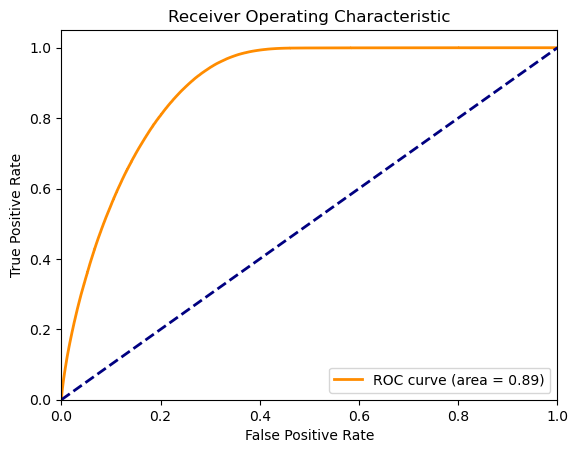

In [12]:
# Import necessary libraries
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc
from flaml import AutoML

# Initialize AutoML
automl = AutoML()

# Define settings for AutoML
settings = {
    "time_budget": 18000,  # total running time in seconds
    "metric": 'roc_auc',  # primary metric
    "task": 'classification',  # task type
    "log_file_name": "automl.log",  # log file
    "seed": 42  # random seed
}

# Train models with AutoML
automl.fit(X_train=X_train, y_train=y_train, **settings)

# Print the best model and its parameters
print(f"Best model: {automl.best_estimator}")
print(f"Best hyperparameters: {automl.best_config}")
print(f"Best ROC-AUC on validation data: {automl.best_loss}")

# Evaluate the best model on the training set
y_train_pred_prob = automl.predict_proba(X_train)[:, 1]
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)

# Evaluate the best model on the test set
y_test_pred_prob = automl.predict_proba(X_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

# Print the train and test ROC-AUC scores
print("Train ROC-AUC Score:", train_roc_auc)
print("Test ROC-AUC Score:", test_roc_auc)

# Plot ROC curve for the best model on the test set
fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Test ROC-AUC Score: 0.8781143572697762 base
## Test ROC-AUC Score: 0.8765779081614977 all encoding
## Test ROC-AUC Score: 0.8770420572344932 no clustering
## Test ROC-AUC Score: 0.8771573237963725 borrowed FT engineering